In [1]:
import sys
sys.path.append("../scripts/")
from ideal_robot import*
from scipy.stats import expon,norm,uniform

In [2]:
# IdealRobotクラスを継承したRobotクラスを作成
class Robot(IdealRobot):
    def __init__(self, pose, agent=None, sensor=None, color="black",
                 noise_per_meter=5, noise_std=math.pi/60,
                 bias_rate_stds=(0.1,0.1),
                 expected_stuck_time=1e100, expected_escape_time=1e-100,
                 expected_kidnap_time=1e100, kidnap_range_x=(-5.0,5.0),kidnap_range_y=(-5.0,5.0)):
        #super()は、IdealRobotのメソッドを呼び出すときに使う関数。IdealRobotの__init__を呼び出している
        super().__init__(pose, agent, sensor, color)
        
        #以下はRobot特有の処理
        #scaleに小石を踏むまでの平均距離指定。「1e-100は、noise_per_meter」= 0 とされたときに、０割りをしないため
        self.noise_pdf = expon(scale=1.0/(1e-100 + noise_per_meter))
        #最初に小石を踏むまでの道のりをセット。rvsはドローのためのメソッド
        self.distance_until_noise = self.noise_pdf.rvs()
        #Θに加える雑音を決めるためのオブジェクト作成
        self.theta_noise = norm(scale=noise_std)
        
        self.bias_rate_nu = norm.rvs(loc=1.0,scale=bias_rate_stds[0])
        self.bias_rate_omega = norm.rvs(loc=1.0,scale=bias_rate_stds[1])
        
        self.stuck_pdf = expon(scale=expected_stuck_time)
        self.escape_pdf = expon(scale=expected_escape_time)
        self.time_until_stuck = self.stuck_pdf.rvs()
        self.time_until_escape = self.escape_pdf.rvs()
        self.is_stuck = False
        self.kidnap_pdf = expon(scale=expected_kidnap_time)
        self.time_until_kidnap = self.kidnap_pdf.rvs()
        rx,ry = kidnap_range_x,kidnap_range_y
        self.kidnap_dist = uniform(loc=(rx[0],ry[0],0.0),scale=(rx[1]-rx[0],ry[1]-ry[0],2*math.pi))
    
    def noise(self, pose, nu, omega, time_interval):
        #呼ばれるたびに次に小石を踏むまでの道のりを経過時間分だけ減らす
        #直進方向、回転方向の走行距離を引いている
        self.distance_until_noise -= abs(nu)*time_interval + self.r*abs(omega)*time_interval
        
        #小石を踏んだ場合
        if self.distance_until_noise <= 0.0:
            #次に小石を踏むまでの距離をセットしなおす
            self.distance_until_noise += self.noise_pdf.rvs()
            #Θに雑音を加える
            pose[2] += self.theta_noise.rvs()
        
        return pose
    
    
    def bias(self,nu,omega):
        #Agentが指定したnuとomegaに対して、それぞれ係数をかける
        return nu * self.bias_rate_nu, omega * self.bias_rate_omega
    
    def stuck(self,nu,omega,time_interval):
        if self.is_stuck:
            self.time_until_escape -= time_interval
            if self.time_until_escape <= 0.0:
                self.time_until_escape += self.escape_pdf.rvs()
                self.is_stuck = False
        else:
            self.time_until_stuck -= time_interval
            if self.time_until_stuck <= time_interval:
                self.time_until_stuck += self.stuck_pdf.rvs()
                self.is_stuck = True
                
        return nu*(not self.is_stuck), omega*(not self.is_stuck)

    def kidnap(self,pose,time_interval):
        self.time_until_kidnap -= time_interval
        
        if self.time_until_kidnap <= 0.0:
            self.time_until_kidnap += self.kidnap_pdf.rvs()
            return np.array(self.kidnap_dist.rvs()).T
        else:
            return pose
        
    
    def one_step(self, time_interval):
        if not self.agent: return
        
        obs =self.sensor.data(self.pose) if self.sensor else None
        nu, omega = self.agent.decision(obs)
        nu, omega = self.bias(nu, omega)  #追加
        nu, omega = self.stuck(nu, omega, time_interval)
        self.pose = self.state_transition(nu, omega, time_interval, self.pose)
        self.pose = self.noise(self.pose, omega, nu, time_interval)
        self.pose = self.kidnap(self.pose,time_interval)

In [3]:
class Camera(IdealCamera):
    def __init__(self,env_map,
                distance_range=(0.5,6.0),
                direction_range=(-math.pi/3,math.pi/3),
                distance_noise_rate=0.1,
                direction_noise=math.pi/90):
        super().__init__(env_map,distance_range,direction_range)#元のinitを呼び出す
        
        self.distance_noise_rate = distance_noise_rate
        self.direction_noise = direction_noise

<IPython.core.display.Javascript object>


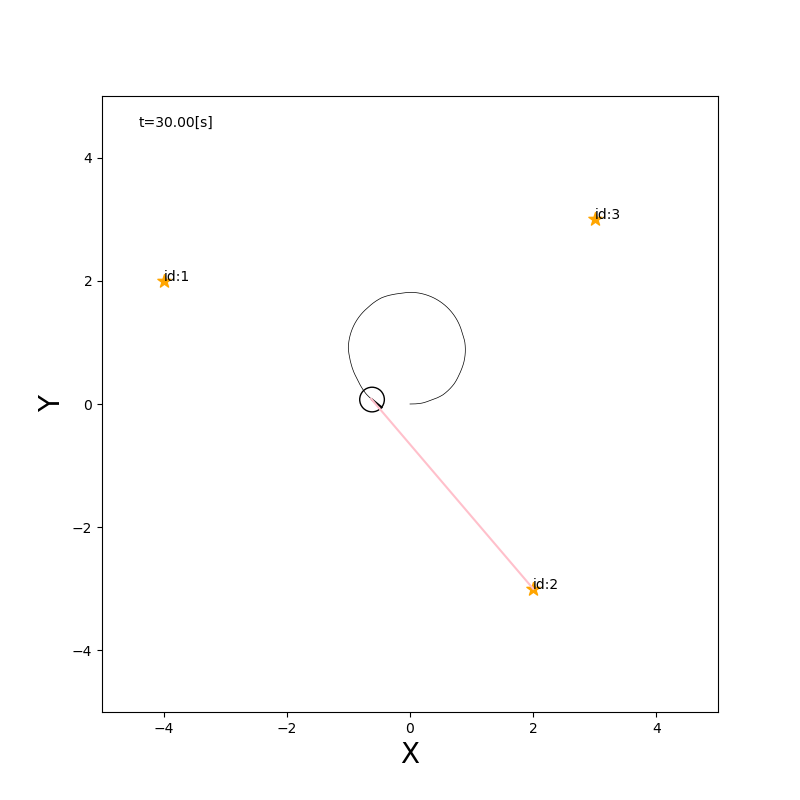

In [4]:
import copy

world = World(30, 0.1)


m = Map()
m.append_landmark(Landmark(-4,2))
m.append_landmark(Landmark(2,-3))
m.append_landmark(Landmark(3,3))
world.append(m)

circling = Agent(0.2, 10.0/180*math.pi)

r = Robot(np.array([0,0,0]).T,sensor=Camera(m),agent=circling)
world.append(r)

#バイアスなしロボット
#nobias_robot = IdealRobot(np.array([0,0,0]).T, sensor=None, agent=circling, color="red")
#world.append(nobias_robot)

#バイアス20%ロボット
#biased_robot = Robot( np.array([0, 0, 0]).T, sensor=None, agent=circling,
#                     color="red", noise_per_meter=0, bias_rate_stds=(0.2,0.2))
#world.append(biased_robot)

#for i in range(10):
    #circling = Agent(0.2, 10.0/180*math.pi)
    #r = Robot(np.array([0,0,0]).T, sensor=None, agent=circling, color="gray", noise_per_meter=0, bias_rate_stds=(0.0,0.0),
              #expected_stuck_time=60.0, expected_escape_time=60.0,
              #expected_kidnap_time = 5)
    #world.append(r)
    
#r = IdealRobot(np.array([0,0,0]).T, sensor=None, agent=circling, color="red")
#world.append(r)

world.draw()
